In [1]:
import sys
import os
import numpy as np
import seaborn.apionly as sns
import astropy.constants as ac
from astropy.table import Table,Column
from astropy.io import ascii
from matplotlib import ticker
import matplotlib.pyplot as plt
plt.style.use('papers')
%matplotlib inline
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_analysis/src/'))
sys.path.append(os.path.join(os.environ['RESEARCH_DIR'],'hercules/hercules/'))
import ebtel_run as ebr
import ebtel_configure as ebc
import ebtel_plot as ebp
import quick_look 

/opt/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/opt/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Hot Plasma Paper 1–Figures, Appendix
Here, we'll build the figure(s) needed for Hot Plasma Paper 1 Appendices. 

* Appendix A: Details on prescription of $c_1$ corrections
* Appendix B: Derivation of two-fluid equations

In [2]:
#input dictionary
config_dict = {'usage_option':'no_dem','rad_option':'rk','dem_option':'new','heat_flux_option':'limited',
              'solver':'rka4','ic_mode':'st_eq','print_plasma_params':'True','heat_species':'electron'}
config_dict['total_time'] = 5000
config_dict['tau'] = 0.1
config_dict['rka_error'] = 1.0e-5
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0
config_dict['h_back'] = 3.5e-5
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 1
config_dict['sample_rate'] = 1
#variable c1 options
config_dict['r3_rad_0'] = 0.6
config_dict['r3_cond_0'] = 6.0

## Appendix A
Show $n(t)$ for the following cases:

 + constant values of 2 and 4 (dotted, black)
 + uncorrected from 2 to 0.6 (blue, dashed)
 + uncorrected from 2 to 4 to 0.6 (red, dashed)
 + corrected from 2 to 0.6 (blue, solid)
 + corrected from 2 to 4 to 0.6 (red, solid)
 
Use the single-fluid, $\tau=500$ s case as an example.

In [3]:
config_dict['t_pulse_half'] = 250
config_dict['h_nano'] = 0.04
config_dict['output_file'] = os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/appendix_a')

Configure the cases.

In [4]:
appendix_a_cases = [
    {'color':sns.color_palette('deep')[0],'style':'solid','label':r'$c_{1,cond}=2$','lc':'True','gc':'True','c1_cond':2.0},
    {'color':sns.color_palette('deep')[0],'style':'dashed','label':r'$c_{1,cond}=2,\,\,\mathrm{uncorrected}$','lc':'False','gc':'False','c1_cond':2.0},
    {'color':sns.color_palette('deep')[2],'style':'solid','label':r'$c_{1,cond}=6$','lc':'True','gc':'True','c1_cond':6.0},
    {'color':sns.color_palette('deep')[2],'style':'dashed','label':r'$c_{1,cond}=6,\,\,\mathrm{uncorrected}$','lc':'False','gc':'False','c1_cond':6.0}
]

Run all of the different cases and save the results.

In [5]:
runner = ebr.Runner(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL_C/bin/'),'')
configurer = ebc.Configurer(config_dict,'')
results = []
for case in appendix_a_cases:
    configurer.config_dictionary['r3_loss_correction'] = case['lc']
    configurer.config_dictionary['r3_grav_correction'] = case['gc']
    configurer.config_dictionary['r3_cond_0'] = case['c1_cond']
    configurer.print_xml_config(config_file=config_dict['output_file']+'.xml')
    runner.run_ebtel_single(config_dict['output_file']+'.xml')
    data = np.loadtxt(config_dict['output_file']+'.txt')
    results.append({'t':data[:,0],'n':data[:,2],'c1':data[:,-3]})

Get the HYDRAD data for a comparison.

In [6]:
ql = quick_look.QuickViewer('/data/datadrive2/HYDRAD_runs/hp1_hydrad_runs/single/HYDRAD_500/Results/')

In [7]:
ql.load_results()
ql.make_timeseries(lower_percent=0.4,upper_percent=0.4)

Plot all of the different cases.

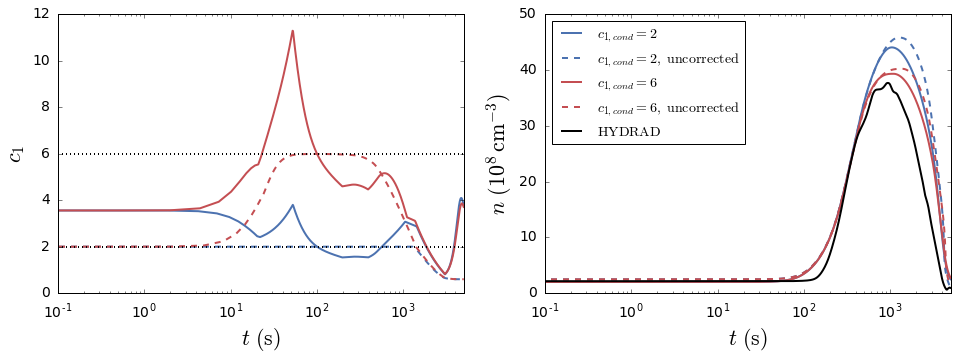

In [8]:
fig,ax = plt.subplots(1,2,figsize=(16,5),sharex=True)
for case,res in zip(appendix_a_cases,results):
    ax[0].plot(res['t'],res['c1'],color=case['color'],label=case['label'],linestyle=case['style'])
    ax[1].plot(res['t'],res['n']/1e+8,color=case['color'],label=case['label'],linestyle=case['style'])
ax[1].plot(ql.time,ql.timeseries['ne']/1e+8,linestyle='solid',color='black',label=r'$\mathrm{HYDRAD}$')
ax[0].axhline(y=2.0,color='black',linestyle='dotted')
ax[0].axhline(y=6.0,color='black',linestyle='dotted')
ax[0].set_xscale('log')
ax[0].set_xlim([0,5000])
ax[1].set_ylim([0,50])
ax[0].set_xlabel(r'$t\,\,(\mathrm{s})$')
ax[1].set_xlabel(r'$t\,\,(\mathrm{s})$')
ax[0].set_ylabel(r'$c_1$')
ax[1].set_ylabel(r'$n\,\,(10^8\,\mathrm{cm}^{-3})$')
ax[1].legend(loc=2)
#plt.tight_layout()
#plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f8.eps',format='eps',dpi=1000)
#plt.show()

Now, we also want to build a table that compares HYDRAD and the old EBTEL results (i.e. $c_{1,cond}=c_{1,eqm}$) with these new corrected results. We will use the four cases from the present paper in addition to the four cases investigated in Cargill (2012a). Only the single-fluid case will be considered.

Construct the headers.

In [9]:
headers = ['$2L$','$\\tau$','$H_0$',
           '$n^{\mathrm{HYDRAD}}_{max}$','$n^{\mathrm{EBTEL}}_{max}$ ',
           '$n^{\mathrm{EBTEL}}_{max}$ (\\autoref{eq:c1_mod})']
units = ['Mm','s','erg cm$^{-3}$ s$^{-1}$','$10^8$ cm$^{-3}$','$10^8$ cm$^{-3}$','$10^8$ cm$^{-3}$']

Build all of the cases.

In [10]:
appendix_a_table_cases = [
    {'hydrad_nmax':30.7,'total_time':5e+3,'loop_length':40.0,'t_pulse_half':10,'h_nano':1,'h_back':3.5e-5},
    {'hydrad_nmax':32.7,'total_time':5e+3,'loop_length':40.0,'t_pulse_half':20,'h_nano':0.5,'h_back':3.5e-5},
    {'hydrad_nmax':37.6,'total_time':5e+3,'loop_length':40.0,'t_pulse_half':100,'h_nano':0.1,'h_back':3.5e-5},
    {'hydrad_nmax':37.7,'total_time':5e+3,'loop_length':40.0,'t_pulse_half':250,'h_nano':0.04,'h_back':3.5e-5},
    {'hydrad_nmax':3.7,'total_time':1e+4,'loop_length':75.0,'h_nano':1.5e-3,'t_pulse_half':250.0,'h_back':2.95e-6},
    {'hydrad_nmax':10.7,'total_time':6e+3,'loop_length':25.0,'h_nano':1e-2,'t_pulse_half':100.0,'h_back':3.19e-5},
    {'hydrad_nmax':339,'total_time':2e+3,'loop_length':25.0,'h_nano':2.0,'t_pulse_half':100.0,'h_back':1.29e-3},
    {'hydrad_nmax':15.5,'total_time':2e+3,'loop_length':25.0,'h_nano':1e-2,'t_pulse_half':100.0,'h_back':4.45e-4},
]

Do all of the runs and build the table.

In [11]:
table_data = []
#set up dictionary class
configurer = ebc.Configurer(config_dict,'')
config_dict['output_file'] = os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/appendix_a')
configurer.config_dictionary['r3_grav_correction'] = 'True'
configurer.config_dictionary['r3_loss_correction'] = 'True'
for t_case in appendix_a_table_cases:
    table_row = []
    #configure main options
    configurer.config_dictionary['total_time'] = t_case['total_time']
    configurer.config_dictionary['loop_length'] = t_case['loop_length']
    configurer.config_dictionary['t_pulse_half'] = t_case['t_pulse_half']
    configurer.config_dictionary['h_nano'] = t_case['h_nano']
    configurer.config_dictionary['h_back'] = t_case['h_back']
    #run w/o correction
    configurer.config_dictionary['r3_cond_0'] = 2.0
    configurer.print_xml_config(config_file=config_dict['output_file']+'.xml')
    runner.run_ebtel_single(config_dict['output_file']+'.xml')
    nmax_uc = np.max(np.loadtxt(config_dict['output_file']+'.txt')[:,2])/1e+8
    #run w/ correction
    configurer.config_dictionary['r3_cond_0'] = 6.0
    configurer.print_xml_config(config_file=config_dict['output_file']+'.xml')
    runner.run_ebtel_single(config_dict['output_file']+'.xml')
    nmax_c = np.max(np.loadtxt(config_dict['output_file']+'.txt')[:,2])/1e+8
    #set table entries
    table_row = [
        2*t_case['loop_length'],
        2*t_case['t_pulse_half'],
        t_case['h_nano'],
        t_case['hydrad_nmax'],
        nmax_uc,
        nmax_c
    ]
    #save to table
    table_data.append(table_row)

Try formatting the table with astropy for better LaTeX printing.

In [12]:
col_table = []
for i in range(len(headers)):
    temp_col = [t[i] for t in table_data]
    col_table.append(temp_col)

In [13]:
aas_table = Table(col_table,names=headers)

In [14]:
aas_table

$2L$,$\tau$,$H_0$,$n^{\mathrm{HYDRAD}}_{max}$,$n^{\mathrm{EBTEL}}_{max}$,$n^{\mathrm{EBTEL}}_{max}$ (\autoref{eq:c1_mod})
float64,float64,float64,float64,float64,float64
80.0,20.0,1.0,30.7,44.45437,39.96935
80.0,40.0,0.5,32.7,44.39466,39.87245
80.0,200.0,0.1,37.6,44.20859,39.55749
80.0,500.0,0.04,37.7,44.05088,39.31924
150.0,500.0,0.0015,3.7,3.808878,3.42007
50.0,200.0,0.01,10.7,11.32344,10.13977
50.0,200.0,2.0,339.0,391.7542,351.0396
50.0,200.0,0.01,15.5,16.33525,14.33859


Write table as an AASTeX deluxetable object.

In [15]:
formats={}
for h,i in zip(headers,range(len(headers))):
    if i==2:
        formats[h] = '%.4f'
    elif i<2:
        formats[h] = '%.0f'
    else:
        formats[h] = '%.1f'

In [16]:
ascii.write(aas_table,output=os.path.join(os.environ['RESEARCH_DIR'],'papers','hot_non-flaring_plasma_1','tables',
                                         'table_a1.tex'),
            format='aastex',formats=formats,
            caption=r'Comparison between HYDRAD and EBTEL with $c_{1,cond}=c_{1,eqm}=2$ and $c_{1,cond}=6$. The first three columns show the full loop length, heating pulse duration, and maximum heating rate. The last three columns show $n_{max}$ for the three models. Only $n_{max}$ is shown as $T_{max}$ is relatively insensitive to the value of $c_1$. The first four rows correspond to the varying pulse durations considered in this paper. The last four rows are the four cases shown in Table 2 of \citet{cargill_enthalpy-based_2012}.',
           latexdict={'units':{h:u for h,u in zip(headers,units)},
                     'tablefoot':r'\label{tab:table_c1_compare}'})

## Appendix B
The first figure will show the relative importance of $\psi_{TR}$ in the EBTEL two-fluid equations. Consider the equation,
$$
\frac{L}{\gamma - 1}\frac{dp_e}{dt} = \psi_{TR} - (\mathcal{R}_C + \mathcal{R}_{TR}) + \frac{L}{\gamma - 1}k_Bn\nu_{ei}(T_i - T_e) + LQ_e.
$$
We want to plot each term as a function of time to show their relative contributions to the evolution of the electron energy.

We will use the following parameters for our sample run:

+ $L=40$ Mm
+ $\tau=200$ s
+ $H_0=0.1$ erg cm$^{-3}$ s$^{-1}$
+ Spitzer conduction

Write function to calculate electron-ion heating frequency.

In [17]:
def calc_nu_ei(n,Te):
    c1 = 16.*np.sqrt(np.pi)/3.
    c2 = ac.e.gauss.value**4/(ac.m_e.cgs.value*ac.m_p.cgs.value)
    c3 = 2.*ac.k_B.cgs.value*Te/ac.m_e.cgs.value
    colLog = 20.
    return c1*c2*c3**(-3./2.)*n*colLog

Configure dictionary to run EBTEL-2fluid model.

In [18]:
#configure input options
config_dict['t_pulse_half'] = 100
config_dict['h_nano'] = 0.1
#variable c1 options
config_dict['r3_loss_correction'] = 'True'
config_dict['r3_grav_correction'] = 'True'
config_dict['r3_sound_speed_correction'] = 'True'
config_dict['output_file'] = os.path.join(os.environ['RESEARCH_DIR'],'research_notebook/figure_builders/hp1_paper_data/appendix_b')

In [19]:
configurer = ebc.Configurer(config_dict,'')

In [20]:
configurer.print_xml_config(config_file=config_dict['output_file']+'.xml')

Now, run the two-fluid EBTEL code with this configuration.

In [21]:
runner = ebr.Runner(os.path.join(os.environ['RESEARCH_DIR'],'EBTEL-2fluid_repo/bin/'),'')

In [22]:
runner.run_ebtel_single(config_dict['output_file']+'.xml')

Next, load the data and plot.

In [23]:
data = np.loadtxt(config_dict['output_file']+'.txt')
t = data[:,0]
Te = data[:,1]
Ti = data[:,2]
n = data[:,3]
fce = data[:,12]
fci = data[:,13]
q = data[:,15]
rad = data[:,-2]
r3 = data[:,-3]

Calculate the relevant quantities.

In [24]:
delta_terms = []
delta_terms.append(fce/(config_dict['loop_length']*1.e+8)/(1.+Te/Ti))
delta_terms.append(-fci/(config_dict['loop_length']*1.e+8)*(Te/Ti)/(1.+Te/Ti))
delta_terms.append(-(Te/Ti*(r3+1.) + 1.)/(1.+Te/Ti)*n**2*rad)
#delta_terms.append(q)
tmp = np.zeros(len(Te))
for i in range(len(Te)):
    tmp[i] = ac.k_B.cgs.value/(5./3. - 1.)*n[i]*calc_nu_ei(n[i],Te[i])*(Ti[i] - Te[i])
delta_terms.append(tmp)

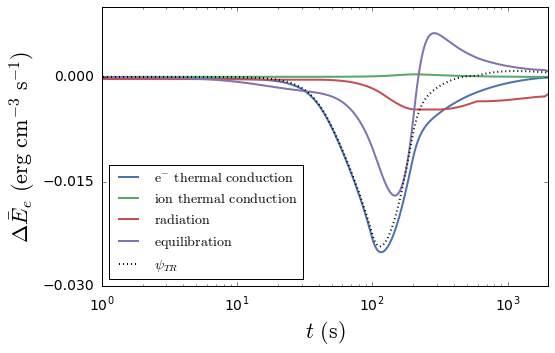

In [25]:
labels = [r'$\mathrm{e}^{-}$ $\mathrm{thermal}$ $\mathrm{conduction}$',
          r'$\mathrm{ion}$ $\mathrm{thermal}$ $\mathrm{conduction}$',
          r'$\mathrm{radiation}$',r'$\mathrm{equilibration}$']
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
#axT = ax.twinx()
for i in range(len(delta_terms)):
        ax.plot(t,delta_terms[i],color=sns.color_palette('deep')[i],label=labels[i])
ax.plot(t,1.0/(config_dict['loop_length']*1.e+8)*1./(1.+Te/Ti)*(fce + (r3*(config_dict['loop_length']*1.e+8)*(n**2)*rad)-Te/Ti*fci),
       linestyle='dotted',color='k',label=r'$\psi_{TR}$')
#axT.plot(t,Te/1e+6,linestyle='dashed',color='k')
ax.set_xscale('log')
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
#ax.set_yscale('log')
ax.set_xlim([1,config_dict['total_time']])
ax.set_xlabel(r'$t$ $\mathrm{(s)}$')
ax.set_ylabel(r'$\Delta\bar{E}_e$ $(\mathrm{erg}$ $\mathrm{cm}^{-3}$ $\mathrm{s}^{-1})$')
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
ax.legend(loc='best')
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/f9.eps',format='eps',dpi=1000)
plt.show()